# Notebook to mess with text mining on total loss analytics task names
* Primary goal is to just look at the degree of similarity among the different tasks (within a prefered category)
    * Default Calendar, claim activity, file notes
    * Can we identify a new subcategory?
    * can we group these tasks by duration?

In [1]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
os.chdir(u'C:/Users/kesj/Documents/projects/total_loss_analytics/task_data/')


In [3]:
fname = 'task_names.csv'


In [4]:
task_names = pd.read_csv(fname)
task_names.shape

(4143951, 5)

In [5]:
task_names.ctgry_cd.value_counts()

DFTCL    1198037
NM        784190
NC        753857
FN        352260
CA        349491
ROCA      204144
EST       150826
PHONE      94099
FC         45197
MGMT       33056
CPA        22822
EBRO       21569
AEBR       17278
CSA        17014
RBR        15708
MWORK      13888
CRA        12248
MBR        11794
TDP        10494
TOW         7811
AU          7587
CAT         6800
FIN         6658
CSAP        2539
MED         2477
NTL         1075
SLVBR        472
MSCBR        434
CAL           98
GBR           28
Name: ctgry_cd, dtype: int64

## start with an easy one:
* ctgry_cd == 'GBR'; only 28 instances

In [6]:
gbr = task_names[task_names.ctgry_cd == 'GBR'].copy()
#gbr

In [7]:
gbr.task_nm.value_counts()

GLASS - PAYMENT REVIEW - 474384705 - LYNX SERVICES, L.L.C.       1
GLASS - BILL NEEDS REVIEW - 471648345 - LYNX SERVICES, L.L.C.    1
GLASS - BILL NEEDS REVIEW - 466639732 - LYNX SERVICES, L.L.C.    1
GLASS - BILL NEEDS REVIEW - 468820353 - LYNX SERVICES, L.L.C.    1
GLASS - BILL NEEDS REVIEW - 469675047 - LYNX SERVICES, L.L.C.    1
GLASS - PAYMENT REVIEW - 464310156 - LYNX SERVICES, L.L.C.       1
GLASS - PAYMENT REVIEW - 469486511 - LYNX SERVICES, L.L.C.       1
GLASS - BILL NEEDS REVIEW - 464245273 - LYNX SERVICES, L.L.C.    1
GLASS - STAFF ASST REVIEW - 464161878 - LYNX SERVICES, L.L.C.    1
GLASS - STAFF ASST REVIEW - 476839874 - LYNX SERVICES, L.L.C.    1
GLASS - PAYMENT REVIEW - 472447998 - LYNX SERVICES, L.L.C.       1
GLASS - PAYMENT REVIEW - 469718145 - LYNX SERVICES, L.L.C.       1
GLASS - BILL NEEDS REVIEW - 470424281 - LYNX SERVICES, L.L.C.    1
GLASS - BILL NEEDS REVIEW - 473749475 - LYNX SERVICES, L.L.C.    1
GLASS - BILL NEEDS REVIEW - 465630766 - LYNX SERVICES, L.L.C. 

In [150]:
fntasks.task_nm.head()

0                          REVIEW FILE NOTE - TDP - V1
1    REVIEW FILE NOTE - V1 stopped by Art's Automot...
2                       REVIEW FILE NOTE - oic contact
3                  REVIEW FILE NOTE - V2 IVIPS request
4                   REVIEW FILE NOTE - Bid Review - CR
Name: task_nm, dtype: object

### define function to extract relevant text

In [8]:
def get_text(df,col,parser='alpha'):
    text_lines = df[col].values.tolist()
    if parser=='alpha':
        # first convert to lowercase
        #text_lines = [line.lower() for line in text_lines]
        #tmp = get_text(gbr,'task_nm')
        text_lines = ["".join(x for x in line.lower() if x.isalpha() or x==' ') for line in text_lines]
    
    return text_lines



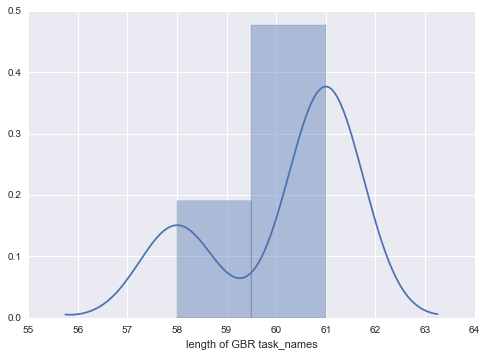

In [9]:
sns.distplot([len(line) for line in get_text(gbr,'task_nm',parser=None)])
plt.xlabel('length of GBR task_names')


In [10]:
tmp = get_text(gbr,'task_nm')
#["".join(x for x in line if x.isalpha() or x==' ') for line in tmp]
#tmp

### Now define symantic/lexical similarity

# Options:
1. by word (n-gram)
2. by character (k-gram?)



## Option 1: by word

In [11]:
import nltk

In [12]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer


In [13]:
count_vectorizer = CountVectorizer()
print(count_vectorizer)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)


### now create the vocab

In [14]:
#gbr_vocab = 
smatrix = count_vectorizer.fit_transform(tmp)
print(count_vectorizer.vocabulary_)

{'services': 8, 'review': 7, 'payment': 6, 'staff': 9, 'llc': 3, 'lynx': 4, 'bill': 1, 'glass': 2, 'needs': 5, 'asst': 0}


In [15]:
#nltk.download()
#print(smatrix.todense())

In [16]:
## 
from sklearn.feature_extraction.text import TfidfTransformer
tfidf = TfidfTransformer(norm="l2")
tfidf_matrix = tfidf.fit_transform(smatrix)
print ("IDF:", tfidf.idf_)

IDF: [ 2.98100147  1.47692407  1.          1.          1.          1.47692407
  2.17007125  1.          1.          2.98100147]


In [17]:
#tfidf_matrix.todense()

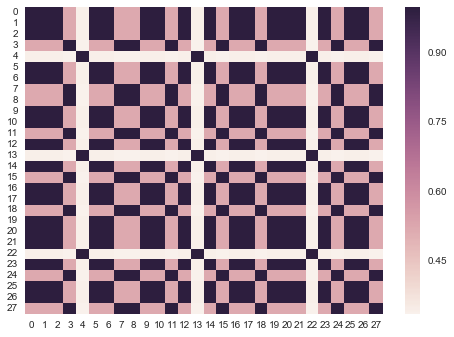

In [18]:
line_by_line = np.dot(tfidf_matrix.todense(),tfidf_matrix.todense().T)
sns.heatmap(line_by_line)

In [19]:
from sklearn import cluster
def cluster_text(X,nclusters=14, random_state= 55, show_plot=True):
    clstr = cluster.KMeans(random_state=random_state, n_clusters=nclusters)
    clstr.fit(X)
    if show_plot:
        obs_per_cluster = pd.Series(clstr.labels_).value_counts()
        obs_per_cluster.plot(kind="bar",color='cadetblue')
        plt.ylabel('Number of Observations')
        plt.xlabel('Cluster ID')
        plt.show()
    return clstr

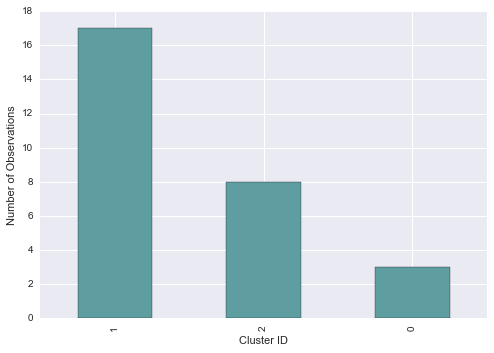

In [20]:
cc = cluster_text(tfidf_matrix)

In [21]:
for cid in np.arange(0,cc.n_clusters):
    my_idx = np.where(cc.labels_==cid)[0]
    print("cluster label %d corresponds to %d observations" % (cid, len(my_idx)))
    if len(my_idx)!= 0:
        print(list(set([tmp[x] for x in my_idx])))

cluster label 0 corresponds to 3 observations
['glass  staff asst review    lynx services llc']
cluster label 1 corresponds to 17 observations
['glass  bill needs review    lynx services llc']
cluster label 2 corresponds to 8 observations
['glass  payment review    lynx services llc']
cluster label 3 corresponds to 0 observations
cluster label 4 corresponds to 0 observations
cluster label 5 corresponds to 0 observations
cluster label 6 corresponds to 0 observations
cluster label 7 corresponds to 0 observations
cluster label 8 corresponds to 0 observations
cluster label 9 corresponds to 0 observations
cluster label 10 corresponds to 0 observations
cluster label 11 corresponds to 0 observations
cluster label 12 corresponds to 0 observations
cluster label 13 corresponds to 0 observations


In [22]:
np.shape(tfidf_matrix) # rows are the observations

(28, 10)

In [23]:

tfidf_matrix[[4,13,22],:].todense().mean(axis=0)

matrix([[ 0.62467561,  0.        ,  0.20955227,  0.20955227,  0.20955227,
          0.        ,  0.        ,  0.20955227,  0.20955227,  0.62467561]])

In [24]:
[tfidf_matrix[a,:].todense()for a in [4,13,22]]

[matrix([[ 0.62467561,  0.        ,  0.20955227,  0.20955227,  0.20955227,
           0.        ,  0.        ,  0.20955227,  0.20955227,  0.62467561]]),
 matrix([[ 0.62467561,  0.        ,  0.20955227,  0.20955227,  0.20955227,
           0.        ,  0.        ,  0.20955227,  0.20955227,  0.62467561]]),
 matrix([[ 0.62467561,  0.        ,  0.20955227,  0.20955227,  0.20955227,
           0.        ,  0.        ,  0.20955227,  0.20955227,  0.62467561]])]

## Explain what terms dominate each group

In [25]:
from sklearn.ensemble import RandomForestClassifier
def plotGroupDetails(X,cluster,terms,nestimators=100):
    nclusters = cluster.n_clusters
    X_dense = X.toarray()
    y = cluster.labels_
    obs_per_cluster = pd.Series(cluster.labels_).value_counts()
    nobs = len(obs_per_cluster)
    if nobs < nclusters:
        nclusters=nobs
    for k in range(nclusters):
        y_binary = pd.Series(y).replace(k, nestimators)
        y_binary = y_binary.replace([e for e in range(nclusters) if e != k], 0)
        Forest = RandomForestClassifier(n_estimators=nestimators)
        Forest.fit(X_dense, y_binary)
        temp = pd.Series(Forest.feature_importances_, index=terms)
        temp.sort_values(ascending=False,inplace=True)
        temp[:7].plot(kind="bar", figsize=(8,3), fontsize=14, grid=False, alpha=0.7, linewidth=0.0)
        plt.xticks(rotation=50, ha="right")
        plt.title("Group %d  (n = %d)" % (k, obs_per_cluster[k]), fontsize=20)
        plt.show()

In [26]:
pd.Series(cc.labels_).value_counts()

1    17
2     8
0     3
dtype: int64

In [27]:
#v2 = tfidf_vectorizer.fit_transform(task_names[task_names.ctgry_cd=='CAL']['task_nm'].values.tolist())
#tfidf_vectorizer.vocabulary_

In [28]:
#nltk.wordpunct_tokenize(" ".join(line for line in task_names[task_names.ctgry_cd=='CAL']['task_nm'].values.tolist()))

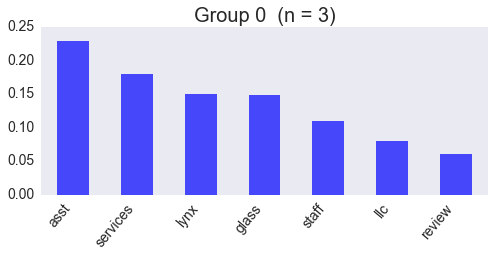

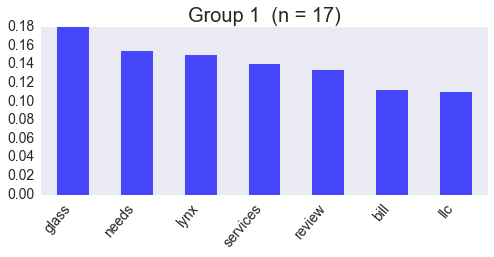

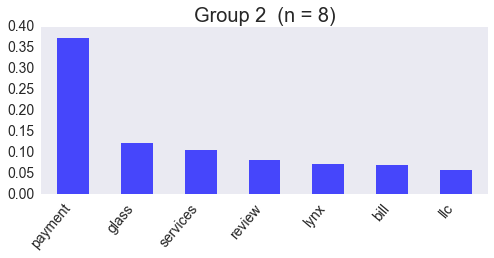

In [29]:
plotGroupDetails(tfidf_matrix,cc, count_vectorizer.get_feature_names())

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix2 = tfidf_vectorizer.fit_transform(tmp)
print (tfidf_matrix2.shape)

(28, 10)


In [31]:
## Calculate the cosine similarity score
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity(tfidf_matrix2[0:1], tfidf_matrix2)


array([[ 1.        ,  1.        ,  1.        ,  0.52442045,  0.34242378,
         1.        ,  1.        ,  0.52442045,  0.52442045,  1.        ,
         1.        ,  0.52442045,  1.        ,  0.34242378,  1.        ,
         0.52442045,  1.        ,  1.        ,  0.52442045,  1.        ,
         1.        ,  1.        ,  0.34242378,  1.        ,  0.52442045,
         1.        ,  1.        ,  0.52442045]])

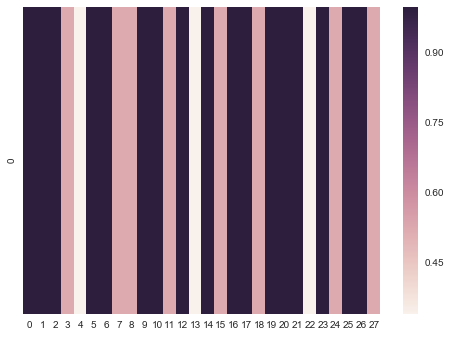

In [32]:
sns.heatmap(cosine_similarity(tfidf_matrix2[0:1], tfidf_matrix2))

In [33]:
myvect = tfidf_matrix2[[4,13,22]].mean(axis=0).tolist()[0]
myvect

[0.6246756117325207,
 0.0,
 0.20955226565857105,
 0.20955226565857105,
 0.20955226565857105,
 0.0,
 0.0,
 0.20955226565857105,
 0.20955226565857105,
 0.6246756117325207]

In [34]:
#tfidf_vectorizer.get_feature_names()
sorted(range(len(myvect)), key= lambda i: myvect[i])[-10:]

[1, 5, 6, 2, 3, 4, 7, 8, 0, 9]

In [35]:
my_features = tfidf_vectorizer.get_feature_names()
for n in np.arange(0,len(myvect)):
    print(n, my_features[n],myvect[n])
t_df = pd.Series(myvect,index=my_features)
t_df


0 asst 0.6246756117325207
1 bill 0.0
2 glass 0.20955226565857105
3 llc 0.20955226565857105
4 lynx 0.20955226565857105
5 needs 0.0
6 payment 0.0
7 review 0.20955226565857105
8 services 0.20955226565857105
9 staff 0.6246756117325207


asst        0.624676
bill        0.000000
glass       0.209552
llc         0.209552
lynx        0.209552
needs       0.000000
payment     0.000000
review      0.209552
services    0.209552
staff       0.624676
dtype: float64

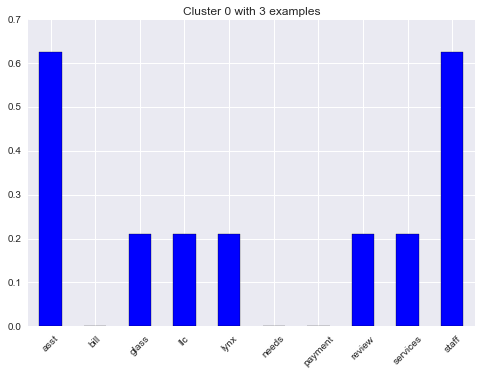

In [36]:
t_df.plot(kind='bar',rot=45)
plt.title('Cluster 0 with 3 examples')

In [37]:
def extract_tfidf_term_fractions(clusters,vectorizor,my_matrix,n_terms = 100):
    vocab = vectorizor.get_feature_names()
    ## get the rows that correspond to a given cluster_label:
    #clust_id = 1
    nclusters = clusters.n_clusters
    
    clst_labels = pd.Series(clusters.labels_)
    nobs = len(clst_labels.value_counts())
    print(nclusters,nobs)
    
    if nobs < nclusters:
        nclusters=nobs
    
    
    for k in range(nclusters):
        obs_idx = clst_labels[clst_labels == k].index.tolist()
        # reduce to the average value for each word
        vect_contributions = my_matrix[obs_idx].mean(axis=0).tolist()[0]
        df_vect = pd.Series(vect_contributions,index=vocab)
        if len(vocab)>n_terms: 
            df_vect.sort_values(ascending=False,inplace=True)
        # just print all of them as they are
        #    
        #    df_vect.plot(kind='bar',color='steelblue',rot=45)
        #else:
        df_vect[:n_terms].plot(kind='bar',color='steelblue',rot=45)
        plt.title("Top terms from Cluster %d (n = %d)" %(k,len(obs_idx)),fontsize=20)
        plt.ylabel('Mean TFIDF value')
        plt.show()    
            
            
    return    
    


14 3


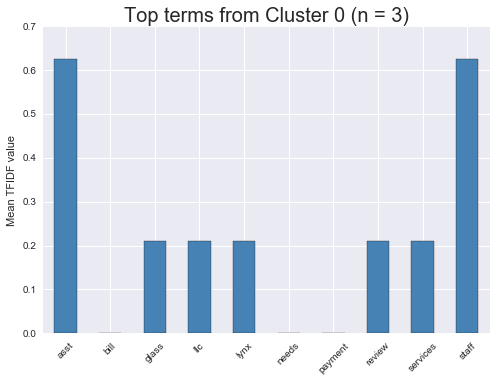

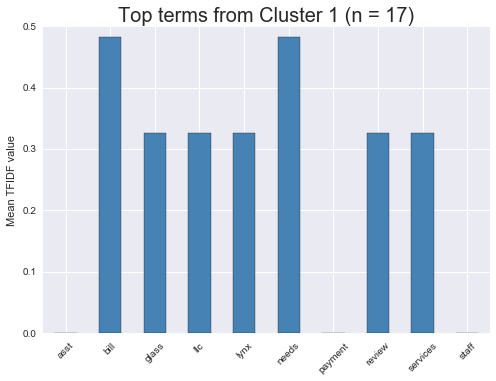

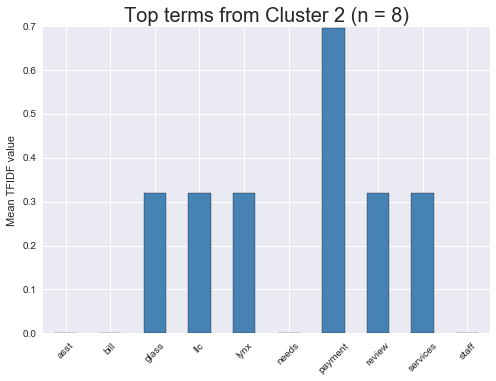

In [38]:
extract_tfidf_term_fractions(cc,tfidf_vectorizer,tfidf_matrix2)

### Try this again on a larger category

In [39]:
print(tfidf_vectorizer)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)


In [40]:
#nltk.word_tokenize(cal_txt[0]), cal_txt[0]

In [41]:
def tfidf_process_category(df,colname,**kwargs):
    # extract the text
    sample_text = get_text(df,colname)
    # work through tfidf vectorizor
    tfidf_vectorizer = TfidfVectorizer(**kwargs)
    ## transform the input
    X =  tfidf_vectorizer.fit_transform(sample_text)
    print (X.shape)
    # cluster the input lines
    cc = cluster_text(X)
    # describe the clusters
    plotGroupDetails(X,cc,tfidf_vectorizer.get_feature_names())
    return X,tfidf_vectorizer,cc

In [42]:
#cal_txt = get_text(task_names[task_names.ctgry_cd=='CAL'],'task_nm')
#cal_txt

(352260, 86272)


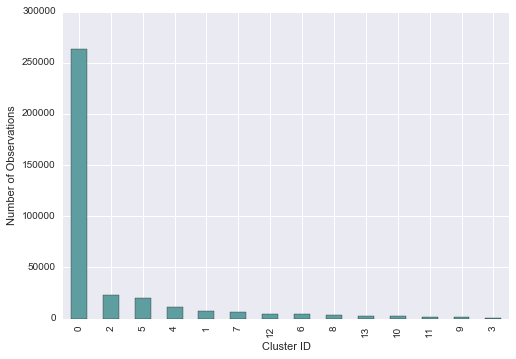

In [43]:
# extract the text
fn_sample_text = get_text(task_names[task_names.ctgry_cd=='FN'],'task_nm')
# work through tfidf vectorizor
fn_tfidf_vectorizer = TfidfVectorizer(ngram_range=[2,3],stop_words='english',min_df=2,max_df=0.95)
    ## transform the input
Xfn =  fn_tfidf_vectorizer.fit_transform(fn_sample_text)
print (Xfn.shape)
# cluster the input lines
fn_cc = cluster_text(Xfn)

14 14


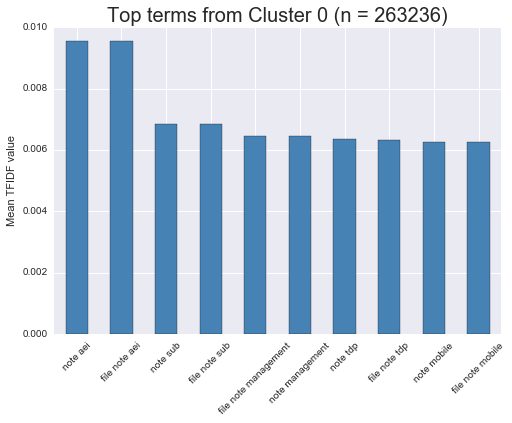

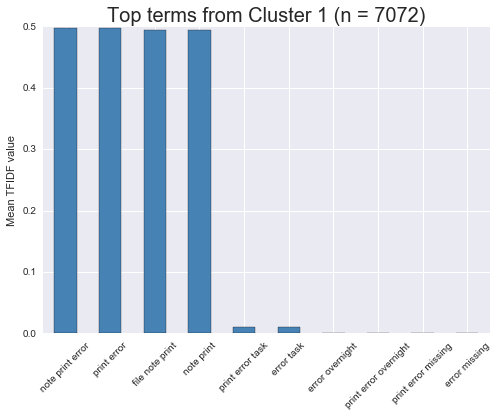

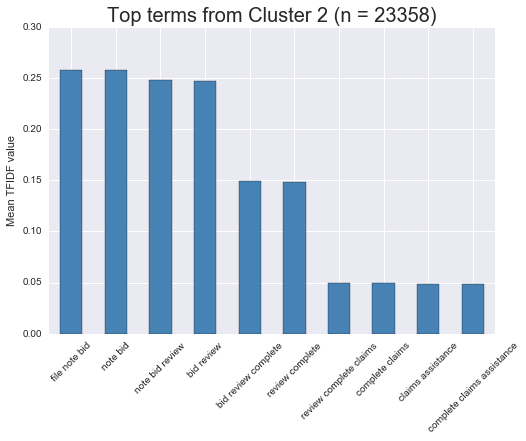

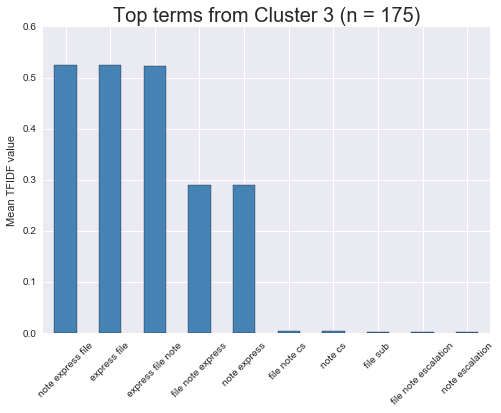

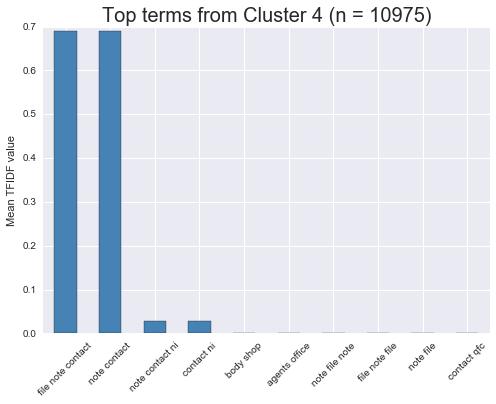

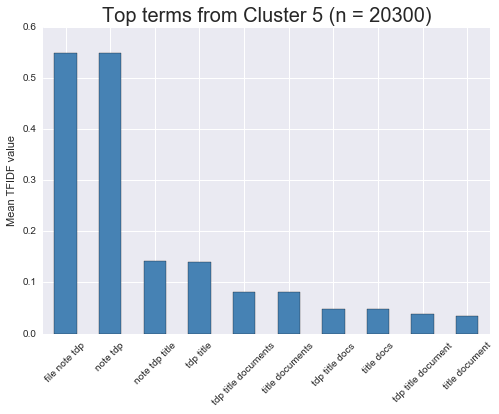

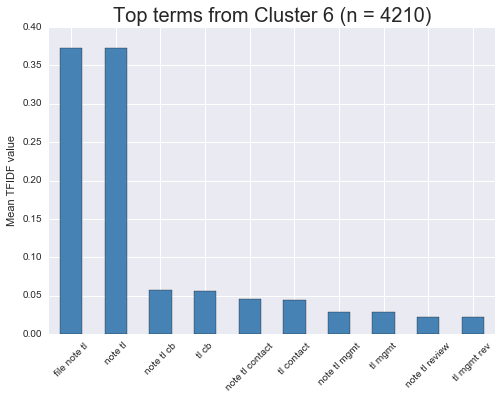

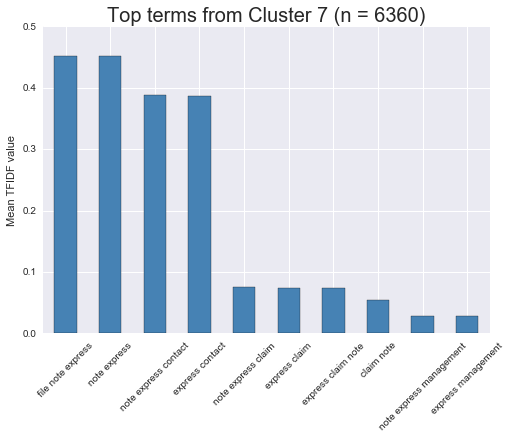

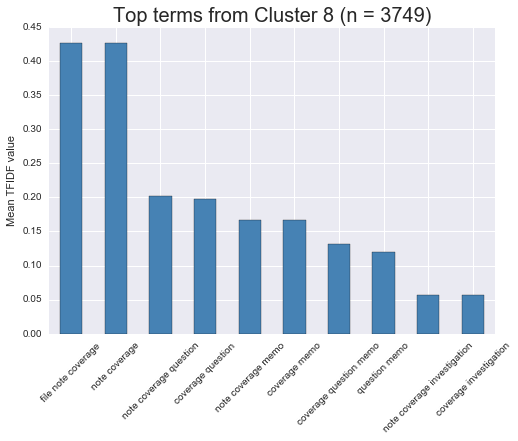

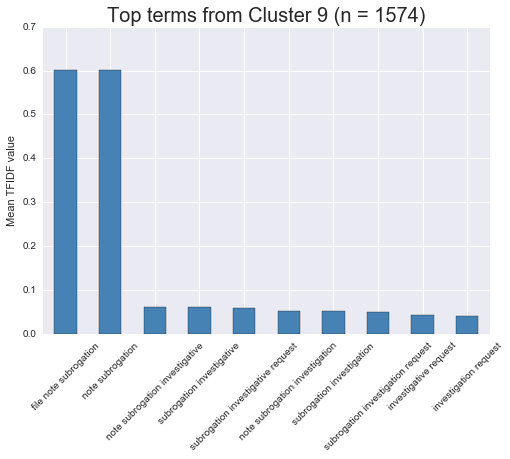

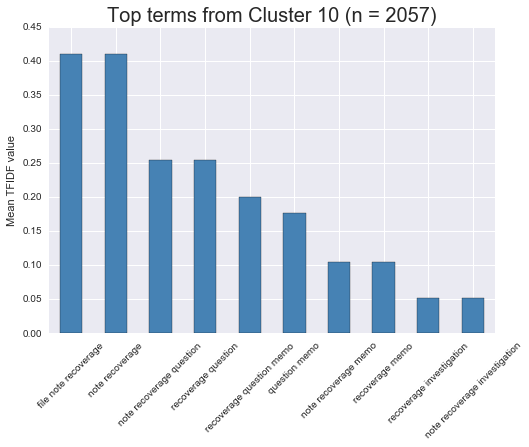

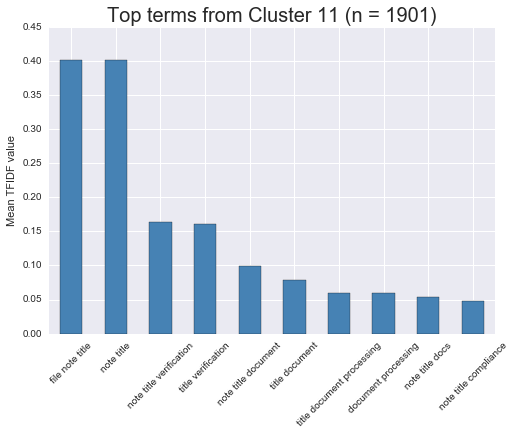

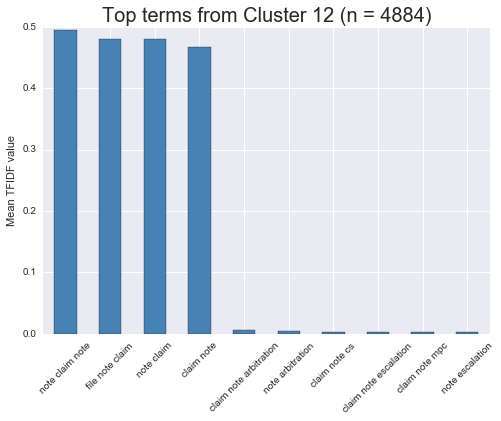

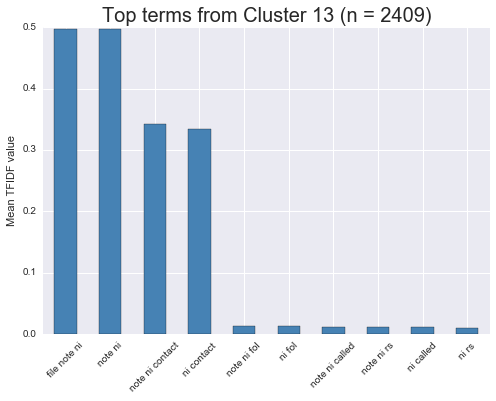

In [44]:
extract_tfidf_term_fractions(fn_cc,fn_tfidf_vectorizer,Xfn,10)

## do I want to check on the durations for these clusters?

In [45]:
fntasks = task_names[task_names.ctgry_cd=='FN'].copy()
fntasks.index = np.arange(0,len(fntasks))
fntasks.head()

,Unnamed: 0,task_nm,ctgry_cd,clm_id,task_desc_txt
0,28,REVIEW FILE NOTE - TDP - V1,FN,0006661485084,Review File Note - TDP - V1
1,38,REVIEW FILE NOTE - V1 stopped by Art's Automot...,FN,0009103726263,Review File Note - V1 stopped by Art's Automot...
2,48,REVIEW FILE NOTE - oic contact,FN,0009452247790,Review File Note - oic contact
3,79,REVIEW FILE NOTE - V2 IVIPS request,FN,0010179635278,Review File Note - V2 IVIPS request
4,114,REVIEW FILE NOTE - Bid Review - CR,FN,0008696263319,Review File Note - Bid Review - CR


In [46]:
#[fn_cc.labels_==9]
label_series = pd.Series(fn_cc.labels_)

fn9_idx = label_series[label_series == 9].index.tolist()
fntasks.ix[fn9_idx]



,Unnamed: 0,task_nm,ctgry_cd,clm_id,task_desc_txt
91,1001,REVIEW FILE NOTE - subrogation,FN,0009866954982,Review File Note - subrogation
599,7148,REVIEW FILE NOTE - Subrogation,FN,0009042308679,Review File Note - Subrogation
667,7998,REVIEW FILE NOTE - Subrogation Investigative R...,FN,0008881152670,Review File Note - Subrogation Investigative R...
1869,21942,REVIEW FILE NOTE - SUBROGATION INVESTIGATION R...,FN,0009164228706,Review File Note - SUBROGATION INVESTIGATION R...
2622,31296,REVIEW FILE NOTE - Subrogation,FN,0008824612550,Review File Note - Subrogation
2738,32562,REVIEW FILE NOTE - Subrogation,FN,0009013299235,Review File Note - Subrogation
3646,42874,REVIEW FILE NOTE - Subrogation,FN,0009881235779,Review File Note - Subrogation
4265,49481,REVIEW FILE NOTE - subrogation,FN,0009336889699,Review File Note - subrogation
4597,53198,REVIEW FILE NOTE - subrogation,FN,0009588768055,Review File Note - subrogation
4680,54268,REVIEW FILE NOTE - Subrogation,FN,0009374651214,Review File Note - Subrogation


# what about LDA?

In [47]:
from time import time
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [53]:
n_samples = 2000
n_features = 1000
n_topics = 10
n_top_words = 20

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" | ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [51]:
print("Fitting LDA models with tf features, n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
lda = LatentDirichletAllocation(n_topics=n_topics, max_iter=5,
                                learning_method='online', learning_offset=50.,
                                random_state=0)
t0 = time()
lda.fit(Xfn)
print("done in %0.3fs." % (time() - t0))



Fitting LDA models with tf features, n_samples=2000 and n_features=1000...
done in 995.799s.

Topics in LDA model:


NameError: name 'fn_tf_vectorizer' is not defined

In [54]:
print("\nTopics in LDA model:")
tf_feature_names = fn_tfidf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)


Topics in LDA model:
Topic #0:
note file | file note file | note assignment | file note assignment | note file note | assignment claim | note assignment claim | claim handling | assignment claim handling | note injury | file note injury | note sip | file note sip | note escalation | file note escalation | handling complete | injury oar | claim handling complete | file note retdp | note retdp
Topic #1:
note aei | file note aei | note ni | file note ni | ni contact | note ni contact | aei note | note aei note | note supplement | file note supplement | aei notes | note aei notes | file note double | note double | double insured | supplement team | note supplement team | note double insured | insured claim | double insured claim
Topic #2:
information needed | additional information | additional information needed | note additional | file note additional | note tl | file note tl | note additional information | note bid | file note bid | reviewstaff assignment | bid reviewstaff | note bid r

In [73]:
np.shape(lda.components_), [fn_tfidf_vectorizer.get_feature_names()[a ] for a in list(top_term_idx)]

((10, 86272),
 ['note file',
  'file note file',
  'note assignment',
  'file note assignment',
  'note file note',
  'assignment claim',
  'note assignment claim',
  'claim handling',
  'assignment claim handling',
  'note injury',
  'file note injury',
  'note sip',
  'file note sip',
  'note escalation',
  'file note escalation',
  'handling complete',
  'injury oar',
  'claim handling complete',
  'file note retdp',
  'note retdp'])

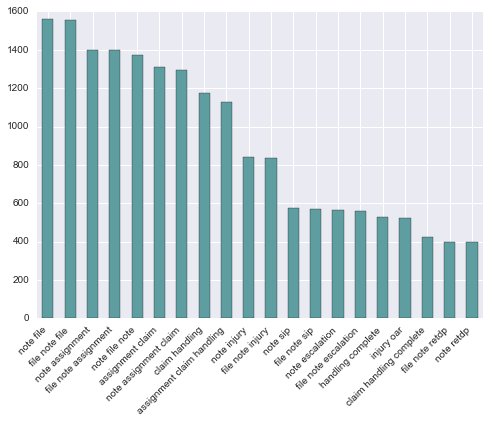

In [76]:
topic0 = lda.components_[0]
top_term_idx = list(topic0.argsort()[:-n_top_words -1 :-1])
top_term_names = [fn_tfidf_vectorizer.get_feature_names()[a] for a in top_term_idx]
tmp = pd.Series(topic0[top_term_idx],index=top_term_names)
tmp.plot(kind='bar',color='cadetblue',rot=45)
plt.xticks( ha="right")
plt.show()

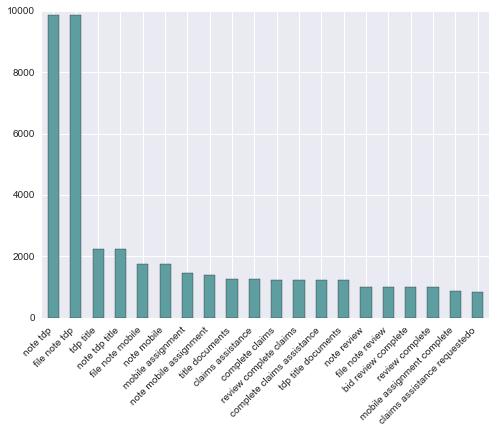

In [146]:
topic0 = lda.components_[5]
top_term_idx = list(topic0.argsort()[:-n_top_words -1 :-1])
top_term_names = [fn_tfidf_vectorizer.get_feature_names()[a] for a in top_term_idx]
tmp = pd.Series(topic0[top_term_idx],index=top_term_names)
tmp.plot(kind='bar',color='cadetblue',rot=45)
plt.xticks( ha="right")
plt.show()

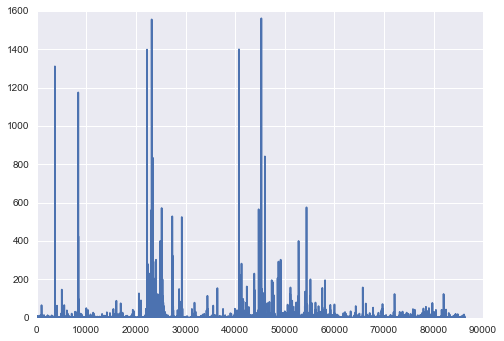

In [90]:
plt.plot(lda.components_[0])

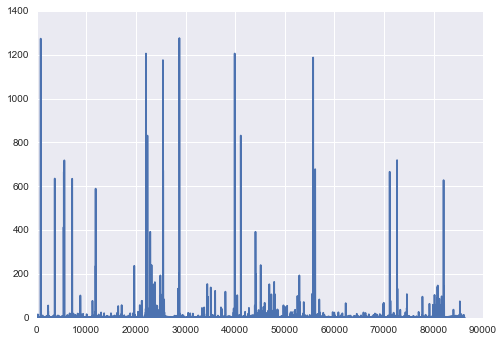

In [149]:
plt.plot(lda.components_[2])

In [92]:
np.shape(Xfn),np.shape(lda.components_)

((352260, 86272), (10, 86272))

In [147]:
lda.score(Xfn)

-6473624.1685439833

In [120]:
np.dot(Xfn[0,:].todense(),lda.components_.T).tolist()[0]

[0.14143218141796743,
 0.14142497588430236,
 0.14142701869686003,
 0.14142242618959808,
 0.14142563885202752,
 13951.937311816979,
 0.14142243202862886,
 0.14142853872862365,
 0.1414295594233993,
 0.1414213807309308]

In [122]:
fn_toLDA = []
for i in range(len(fn_sample_text)):
    fn_toLDA.append(np.dot(Xfn[i].todense(),lda.components_.T).tolist()[0])

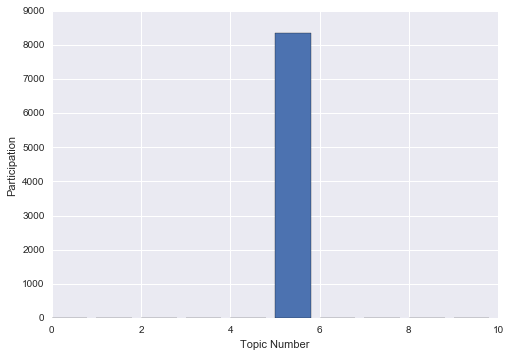

In [136]:
plt.bar(np.arange(0,n_topics),fn_toLDA[800])#[2])
plt.xlabel('Topic Number')
plt.ylabel('Participation')

In [143]:
topic5list =[]
for k in np.arange(0,8000):
    if fn_toLDA[k][5]>5000:
        topic5list.append(k)
#(fn_toLDA[:][5]>5000.).index
len(topic5list)

689

In [145]:
[fn_sample_text[a] for a in topic5list]

['review file note  tdp  v',
 'review file note  tdp',
 'review file note  tdp',
 'review file note  tdp title documents',
 'review file note  tdp title doc processing',
 'review file note  tdp v improper documents',
 'review file note  v tdp',
 'review file note  tdp',
 'review file note  tdp title documents',
 'review file note  tdp v',
 'review file note  tdp v',
 'review file note  tdp v',
 'review file note  tdp',
 'review file note  tdp title document',
 'review file note  tdp title documents',
 'review file note  tdp title documents',
 'review file note  v tdp',
 'review file note  tdp veh',
 'review file note  tdp pending v',
 'review file note  tdp title documents',
 'review file note  tdp title documents',
 'review file note  tdp move',
 'review file note  tdp',
 'review file note  v tdp',
 'review file note  tdp title doc processing',
 'review file note  tdp',
 'review file note  tdp',
 'review file note  tdp title documents',
 'review file note  tdp v',
 'review file note  

In [137]:
fn_sample_text[800]

'review file note  v  tdp title docs'

In [135]:
fn_sample_text[700]

'review file note  prt mgmt'

In [ ]:
## now sum this up
np.array(fn_toLDA)

In [103]:
fn_sample_text[:5]

['review file note  tdp  v',
 'review file note  v stopped by arts automotive in berkeley ca spok',
 'review file note  oic contact',
 'review file note  v ivips request',
 'review file note  bid review  cr']

In [ ]:

def plot_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        plt.title("Topic #%d:" % topic_idx)
        
        #print(" | ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [78]:
## generating bi-grams
input_list = ['all', 'this', 'happened', 'more', 'or', 'less']

def find_bigrams(input_list):
    bigram_list = []
    for i in range(len(input_list)-1):
        bigram_list.append((input_list[i], input_list[i+1]))
    return bigram_list

In [79]:
find_bigrams(input_list)

[('all', 'this'),
 ('this', 'happened'),
 ('happened', 'more'),
 ('more', 'or'),
 ('or', 'less')]

In [80]:
def find_bigrams(input_list):
    return zip(input_list, input_list[1:])

In [81]:
find_bigrams(input_list)

In [82]:
def find_ngrams(input_list, n):
    return zip(*[input_list[i:] for i in range(n)])

In [84]:
[a for a in find_ngrams(input_list,4)]

[('all', 'this', 'happened', 'more'),
 ('this', 'happened', 'more', 'or'),
 ('happened', 'more', 'or', 'less')]

In [ ]:
# Fit the NMF model
print("Fitting the NMF model with tf-idf features,"
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_topics, random_state=1, alpha=.1, l1_ratio=.5).fit(Xfn)
exit()
print("done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model:")
tfidf_feature_names = fn_tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)



Fitting the NMF model with tf-idf features,n_samples=2000 and n_features=1000...
done in 51.530s.

Topics in NMF model:
Topic #0:
file note tdp note tdp tdp additional note tdp additional note tdp veh tdp veh tdp additional information note tdp update tdp update note tdp unable tdp unable tdp title document note tdp mail tdp mail tdp unable complete unable complete title document note tdp pending tdp pending tdp title docs
Topic #1:
file note contact note contact note contact ni contact ni note contact clmt contact clmt note contact express contact express note contact oic contact oic note contact ao contact ao note contact insured note contact lh contact insured contact lh note contact cd contact cd note contact shop contact shop
Topic #2:
note bid file note bid note bid review bid review bid review complete review complete review complete claims complete claims complete claims assistance claims assistance review complete cr complete cr claims assistance requestedo assistance requeste

In [156]:
#sns.distplot(list(fn_tfidf_vectorizer.vocabulary_.values()))


In [169]:
len([text for text in fn_sample_text if 'review file note' not in text]) # how many don't have review file note in them

1329

(352260, 1419244)


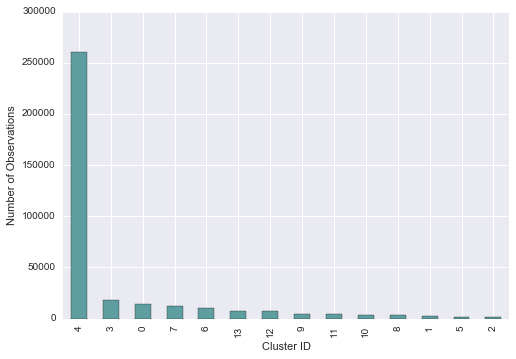

In [167]:
# extract the text
#fn_sample_text = get_text(fntasks,'task_nm')
# work through tfidf vectorizor
#fn_tfidf_vectorizer2 = TfidfVectorizer(ngram_range=[1,5],min_df = 0.05)
fn_tfidf_vectorizer2 = TfidfVectorizer(ngram_range=[2,6],max_df = 0.9)
    ## transform the input
Xfn2 =  fn_tfidf_vectorizer2.fit_transform(fn_sample_text)
print (Xfn2.shape)
# cluster the input lines
fn_cc2 = cluster_text(Xfn2)

In [168]:
#Xfn, fn_tfidf, fn_cc = tfidf_process_category(fntasks,'task_nm')
fn_tfidf_vectorizer2.get_feature_names()[:30]

['aa ab',
 'aa ab vehicle',
 'aa ab vehicle was',
 'aa ab vehicle was dr',
 'aa glass',
 'aa glass for',
 'aa glass for reimb',
 'aa please',
 'aa please review',
 'aaa and',
 'aaa and ifw',
 'aaa asking',
 'aaa asking for',
 'aaa asking for status',
 'aaa asking for status expld',
 'aaa asking for status expld it',
 'aaa called',
 'aaa checking',
 'aaa checking on',
 'aaa checking on status',
 'aaa checking on status of',
 'aaa checking on status of the',
 'aaa checking status',
 'aaa checking status of',
 'aaa checking status of demand',
 'aaa checking status of demand sent',
 'aaa claim',
 'aaa claim number',
 'aaa contact',
 'aaa faxed']

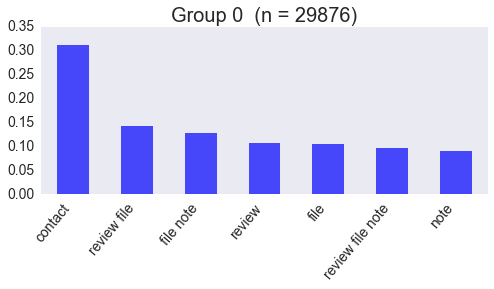

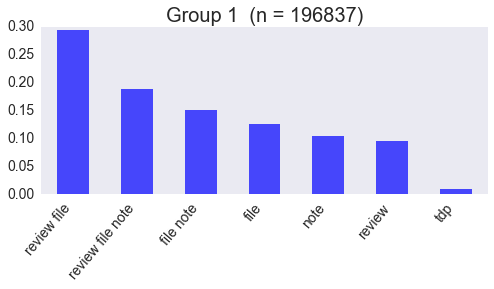

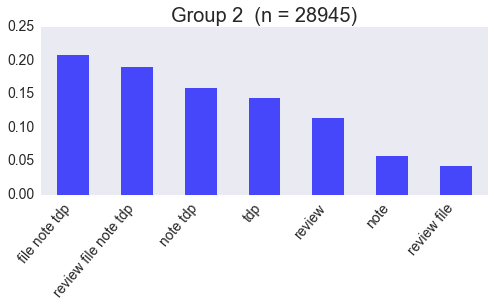

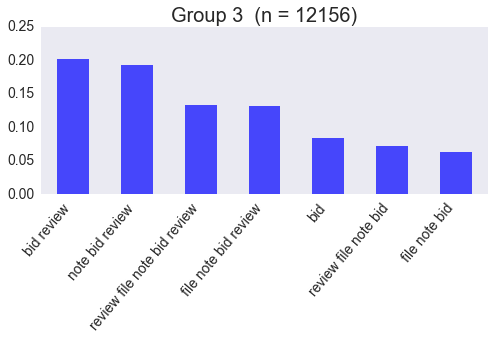

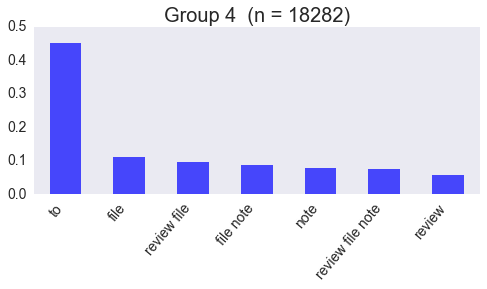

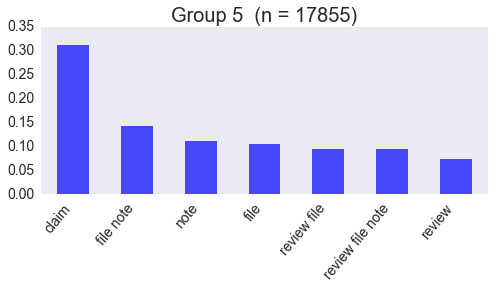

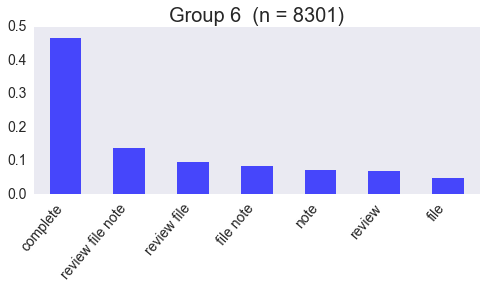

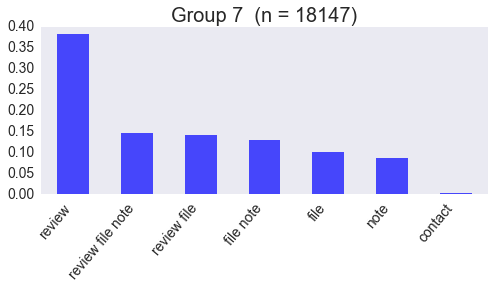

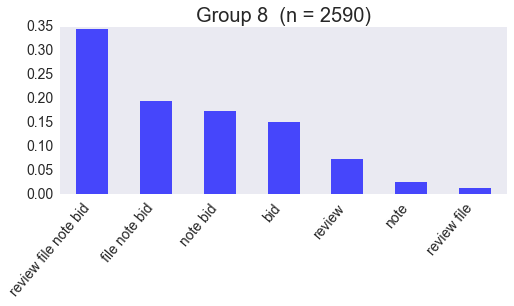

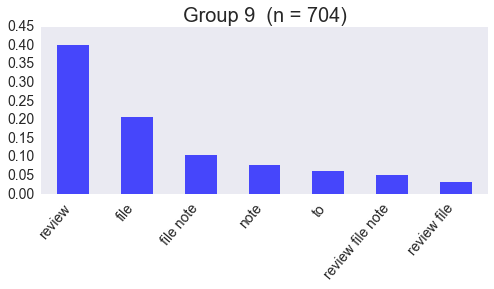

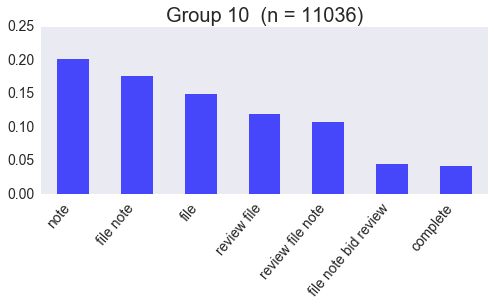

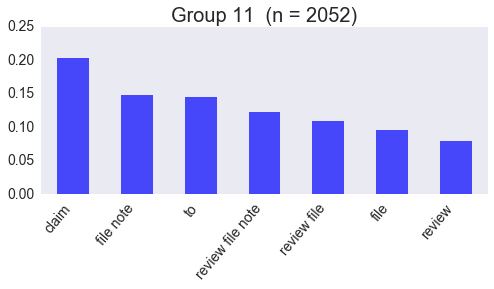

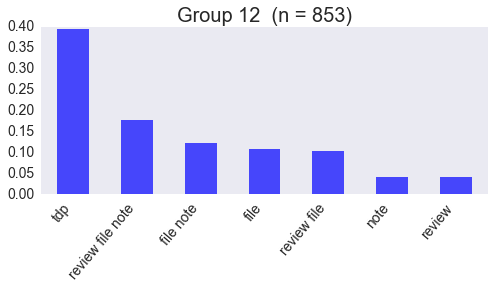

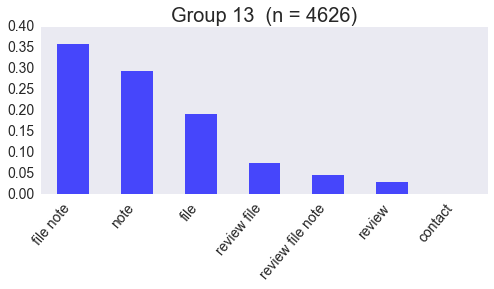

In [161]:
plotGroupDetails(Xfn2,fn_cc2, fn_tfidf_vectorizer2.get_feature_names())

In [164]:
fn_tfidf_vectorizer2.vocabulary_, fn_tfidf_vectorizer2.idf_

({'bid': 0,
  'bid review': 1,
  'claim': 2,
  'complete': 3,
  'contact': 4,
  'file': 5,
  'file note': 6,
  'file note bid': 7,
  'file note bid review': 8,
  'file note tdp': 9,
  'note': 10,
  'note bid': 11,
  'note bid review': 12,
  'note tdp': 13,
  'review': 14,
  'review file': 15,
  'review file note': 16,
  'review file note bid': 17,
  'review file note bid review': 18,
  'review file note tdp': 19,
  'tdp': 20,
  'to': 21},
 array([ 3.60646817,  3.7136041 ,  3.86380183,  3.79515733,  3.43510598,
         1.00356051,  1.00372577,  3.62612539,  3.7300963 ,  3.49780095,
         1.00370582,  3.6258508 ,  3.72987866,  3.49780095,  1.00280583,
         1.00414186,  1.00415897,  3.62636081,  3.73031398,  3.49783546,
         3.4622421 ,  3.76234503]))

## wait I'm missing the V1 stuff

In [150]:
np.shape(Xfn)

NameError: name 'Xfn' is not defined

In [104]:
fntasks = task_names[task_names.ctgry_cd=='FN'].copy()
len(fntasks)

352260

In [105]:
fntasks.task_nm.nunique()

124630

## think about preprocessing

In [123]:
uniq_names = fntasks.task_nm.unique().tolist()
len([line for line in uniq_names if 'V1' in line or 'V2' or 'VEH1' in line])

124630

## try to use the claim_acroynms Yiyun wrote

In [111]:
os.chdir('../claim_acronyms')
%ls

 Volume in drive C is OS
 Volume Serial Number is 222B-1C6E

 Directory of C:\Users\kesj\Documents\projects\total_loss_analytics\claim_acronyms

02/25/2016  11:28 AM    <DIR>          .
02/25/2016  11:28 AM    <DIR>          ..
02/25/2016  11:28 AM    <DIR>          acronyms
02/25/2016  11:28 AM             7,546 demo_acronyms.ipynb
02/25/2016  11:28 AM               263 README.md
               2 File(s)          7,809 bytes
               3 Dir(s)  85,084,286,976 bytes free


In [114]:
import acronyms.acronyms as acro
clm_dict = acro.get_acronyms_dict()

In [116]:
len(clm_dict.keys())

1121

In [118]:
'Veh1' in clm_dict.keys()

False

In [122]:
len([value for value in clm_dict.values() if '/' in value])

119

In [131]:
import re


[]

In [142]:
veh_pattern = r"\b[vV][eE]*[hH]*[\s#]*[0-9]\b"#\w+(?:[-'/]\w+)*|'|[-.(]+|\S\w*"''
re.findall(veh_pattern,uniq_names[123])

['Veh #1']

In [146]:
some_examples = 'Veh1 then veh#1'

In [147]:
re.findall(veh_pattern,some_examples)

['Veh1', 'veh#1']

In [141]:
uniq_names[120:300]

['REVIEW FILE NOTE - TN ESUBRO COMPLETE',
 'REVIEW FILE NOTE - LH Payment Instructions for V1',
 'REVIEW FILE NOTE - I/V INSPECTION AT RON MIDDLE',
 'REVIEW FILE NOTE - RE:Veh #1',
 'REVIEW FILE NOTE - V1 Task was\xa0advise clear title approved for unreco',
 'REVIEW FILE NOTE - Bid Review Complete - Potential Total Loss(VIR Sub',
 'REVIEW FILE NOTE - TDP V2 Branding',
 'REVIEW FILE NOTE - c/c contact',
 'REVIEW FILE NOTE - RE:Reviewed on calendar.V1 salvage is closed and reco',
 'REVIEW FILE NOTE - Bid Review Incomplete - Revisions Requested(VEH 1',
 'REVIEW FILE NOTE - DOP in images for supplement',
 'REVIEW FILE NOTE - authority update',
 'REVIEW FILE NOTE - Thank you for sending this claim to Subrogation Se',
 'REVIEW FILE NOTE - received $ 505.00 from nationwideposted $ 505.00 t',
 'REVIEW FILE NOTE - SUB NOTE',
 'REVIEW FILE NOTE - Express Claim Note',
 'REVIEW FILE NOTE - TDP V1',
 'REVIEW FILE NOTE - Bid Review-Staff Assignment CancelledEC- Estimate',
 'REVIEW FILE NOTE - clmt c

In [ ]:
vehicle_dictionary = {'V1':'vehicle1','VEH1':'vehicle1','V2':'vehicle2','VEH2':'vehicle2'}

In [ ]:
## look for Vx or VEHx
veh_pattern = 

### trying to deal with tfidf information

In [171]:
# deal with 'stop words'
import sklearn.feature_extraction.text
en_stop_list = set(sklearn.feature_extraction.text._check_stop_list('english'))
print(len(en_stop_list))

#filtered = [w for w in tokens if not w in stopwords.words('english')]
#count = Counter(filtered)
#print count.most_common(100)

318


In [175]:
#[word for word in en_stop_list if len(word)==2]


(352260, 1033430)


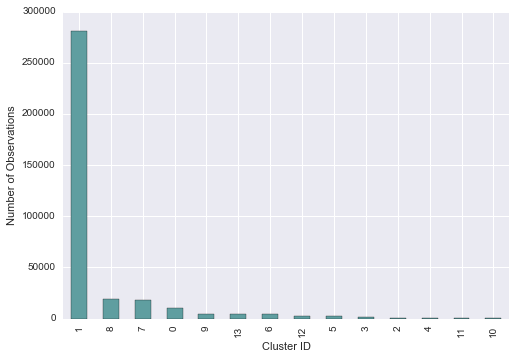

In [174]:
fn_tfidf_vectorizer3 = TfidfVectorizer(ngram_range=[2,6],max_df = 0.9,stop_words=en_stop_list)
    ## transform the input
Xfn3 =  fn_tfidf_vectorizer3.fit_transform(fn_sample_text)
print (Xfn3.shape)
# cluster the input lines
fn_cc3 = cluster_text(Xfn3)

In [176]:
fn_tfidf_vectorizer3.get_feature_names()[:30]

['aa ab',
 'aa ab vehicle',
 'aa ab vehicle dr',
 'aa glass',
 'aa glass reimb',
 'aa review',
 'aaa accepted',
 'aaa accepted liability',
 'aaa accepted liability wil',
 'aaa accptg',
 'aaa accptg liab',
 'aaa accptg liab ni',
 'aaa accptg liab ni atty',
 'aaa asking',
 'aaa asking status',
 'aaa asking status expld',
 'aaa asking status expld appea',
 'aaa called',
 'aaa checking',
 'aaa checking status',
 'aaa checking status demand',
 'aaa checking status demand sent',
 'aaa claim',
 'aaa claim number',
 'aaa clmt',
 'aaa clmt katrina',
 'aaa clmt katrina salas',
 'aaa contact',
 'aaa dmgs',
 'aaa faxed']

## LDA example

In [178]:
from time import time
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [179]:
n_samples = 2000
n_features = 1000
n_topics = 10
n_top_words = 20

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [180]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, #max_features=n_features,
                                   stop_words='english')

In [181]:
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(fn_sample_text)
print("done in %0.3fs." % (time() - t0))

done in 3.517s.


In [183]:
# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=n_features,
                                stop_words='english')
t0 = time()
tf = tf_vectorizer.fit_transform(fn_sample_text)
print("done in %0.3fs." % (time() - t0))

Extracting tf features for LDA...
done in 3.569s.


In [ ]:
# Fit the NMF model
print("Fitting the NMF model with tf-idf features,"
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_topics, random_state=1, alpha=.1, l1_ratio=.5).fit(tfidf)
exit()
print("done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model:")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

print("Fitting LDA models with tf features, n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
lda = LatentDirichletAllocation(n_topics=n_topics, max_iter=5,
                                learning_method='online', learning_offset=50.,
                                random_state=0)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

Fitting the NMF model with tf-idf features,n_samples=2000 and n_features=1000...
done in 34.623s.

Topics in NMF model:
Topic #0:
tdp veh update unable task mail pending docs authority doc draft complete documents email pkg vendor activity needed instructions incomplete
Topic #1:
contact ni clmt ilr oic ao tl insd shop injury ctlu bs insured lh acc property cd dd cs agent
Topic #2:
bid complete cr assistance claims requestedo est completecr requested total completeoriginalsupp potential incomplete lossvir sub completeoriginal loss reviewstaff cancelledec ach
Topic #3:
claim handling double insured set subrogation close companion services assignment ready status tl closed new update dw sending existing thank
Topic #4:
print error destruction lincoln csa completed task char complete bundle draft atl letter close overnight unapproved rework trying msg errormissing
Topic #5:
aei inspection notes estimate appraiser inspectiondiscussed staff supplement vis cancelledec reviewstaff inspected v

NameError: name 'np' is not defined

In [ ]:
pp1 = [line for line in ]

In [ ]:
try:
    from xml.etree.cElementTree import XML
except ImportError:
    from xml.etree.ElementTree import XML
import zipfile


"""
Module that extract text from MS XML Word document (.docx).
(Inspired by python-docx <https://github.com/mikemaccana/python-docx>)
"""

WORD_NAMESPACE = '{http://schemas.openxmlformats.org/wordprocessingml/2006/main}'
PARA = WORD_NAMESPACE + 'p'
TEXT = WORD_NAMESPACE + 't'


def get_docx_text(path):
    """
    Take the path of a docx file as argument, return the text in unicode.
    """
    document = zipfile.ZipFile(path)
    xml_content = document.read('word/document.xml')
    document.close()
    tree = XML(xml_content)

    paragraphs = []
    for paragraph in tree.getiterator(PARA):
        texts = [node.text
                 for node in paragraph.getiterator(TEXT)
                 if node.text]
        if texts:
            paragraphs.append(''.join(texts))

    return '\n\n'.join(paragraphs)


In [ ]:
texts = [node.text
for node in paragraph.getiterator(TEXT)
if node.text.encode('ascii', 'ignore')] 


In [ ]:
txt = get_docx_text('November Hack Day Data/DiscoveryAnalytics StaffNotes 10Oct2014.docx')
txt = txt.encode('ascii','ignore')

In [ ]:
lines = txt.split('\n')

In [ ]:
print len(lines), lines

In [ ]:
##
import nltk
import string

from collections import Counter

def get_tokens():
   with open('../../../data/projGut/pg100.txt', 'r') as shakes:
    text = shakes.read()
    lowers = text.lower()
    #remove the punctuation using the character deletion step of translate
    no_punctuation = lowers.translate(None, string.punctuation)
    #tokens = nltk.word_tokenize(no_punctuation)
    tokens = no_punctuation.split(' ')
    tokens2 = [t for t in tokens if t != '']#.remove('')
    return tokens2

tokens = get_tokens()
count = Counter(tokens)
print count.most_common(10)

In [ ]:
# deal with 'stop words'
stopwords = stoplist = set(sklearn.feature_extraction.text._check_stop_list('english'))


filtered = [w for w in tokens if not w in stopwords.words('english')]
count = Counter(filtered)
print count.most_common(100)